<a href="https://colab.research.google.com/github/Danny2173/RAGproject/blob/main/7_Generator_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and Installs

In [28]:
# Install dependencies
%pip install -q transformers faiss-cpu peft tqdm scikit-learn nltk matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os, json, re, pickle, itertools
import numpy as np
import pandas as pd
import torch
import faiss
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.stem import PorterStemmer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from transformers import (
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DPRContextEncoder,
    DPRContextEncoderTokenizer,
    LogitsProcessor,
    LogitsProcessorList
)
from peft import PeftModel


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load LoRA adapter weights

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load tokenizer and LoRA model
tokenizer = AutoTokenizer.from_pretrained("t5-large")
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-large")
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/t5-lora-final")
model = model.to(device)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

##Loading necessary documents for FAISS Indexing

In [3]:
with open("/content/drive/MyDrive/corpus_texts.pkl", "rb") as f:
    corpus_texts = pickle.load(f)

with open("/content/drive/MyDrive/normalized_for_index.pkl", "rb") as f:
    normalized_for_index = pickle.load(f)

with open("/content/drive/MyDrive/corpus.pkl", "rb") as f:
    corpus = pickle.load(f)

index = faiss.read_index("/content/drive/MyDrive/faiss_index.index")


## Heading Match Count

In [4]:
def count_heading_term_matches(doc_text, matched_main_terms):
    # Normalize text and main terms
    doc_text = doc_text.lower()
    matched_main_terms = set(matched_main_terms)

    # Extracting titles and section headings
    title_match = re.match(r"^(.*?)\n", doc_text)
    title = title_match.group(1) if title_match else ""

    section_matches = re.findall(r"^section:\s*(.*?)$", doc_text, flags=re.MULTILINE)
    subsection_matches = re.findall(r"^subsection:\s*(.*?)$", doc_text, flags=re.MULTILINE)
    subsubsection_matches = re.findall(r"^subsubsection:\s*(.*?)$", doc_text, flags=re.MULTILINE)

    # Combining titles with section headings
    heading_text = " ".join([title] + section_matches + subsection_matches + subsubsection_matches)

    # Tokenize heading text for comparison
    heading_tokens = set(re.findall(r'\b\w[\w\s\-]*\w\b', heading_text))

    # Count matches
    match_count = sum(1 for term in matched_main_terms if term in heading_text)

    return match_count


## Importing Term Normalization functions

In [5]:
# Importing conversion functions

with open("/content/drive/MyDrive/filtered_term_to_CUI.pkl", "rb") as f:
    term_to_CUI = pickle.load(f)

with open("/content/drive/MyDrive/filtered_cui_to_main_term.pkl", "rb") as f:
    cui_to_main_term = pickle.load(f)

# Creating ngrams and tracking indices
def ngram_tokenize_tokens(tokens, max_len=5):
    ngrams = []
    for i in range(len(tokens)):
        for j in range(i + 1, min(i + 1 + max_len, len(tokens) + 1)):
            span = tokens[i:j]
            ngram = ' '.join(span)
            ngrams.append((ngram, i, j))
    return ngrams

# Normalizing medical terms using main condition name
def cui_normalization(sentence, max_ngram_len=5):
    tokens = re.findall(r'\w+|\W+', sentence)

    # Filtering out words
    words = [w.lower() for w in tokens if re.match(r'\w+', w)]

    # Call tokenization function to return ngrams tuples
    ngrams = ngram_tokenize_tokens(words, max_ngram_len)
    replacements = []

    # Tracking matched CUIs
    matched_cuis = set()

    # Searching for terms in dictionary
    for ngram, start, end in ngrams:
        if ngram in term_to_CUI:
            cui = term_to_CUI[ngram]
            if cui in cui_to_main_term:
                replacements.append((start, end, cui_to_main_term[cui]))
                matched_cuis.add(cui)

    # Sorting by length then index (ensure longer terms first)
    replacements.sort(key=lambda x: (x[0], -(x[1] - x[0])))
    used = set()
    final = []
    # Ensure no overlap (check already used indices)
    for start, end, main_term in replacements:
        if not any(i in used for i in range(start, end)):
            final.append((start, end, main_term))
            used.update(range(start, end))

    # Reconstruct the sentence
    word_idx = 0
    output = []
    i = 0
    while i < len(tokens):
        # If the token is a word
        if re.match(r'\w+', tokens[i]):
            # Checking if index appears in final
            match = next((f for f in final if f[0] == word_idx), None)
            if match:
                output.append(match[2]) # append main term
                skip = match[1] - match[0]
                while skip > 0 and i < len(tokens):
                    if re.match(r'\w+', tokens[i]):
                        skip -= 1
                    i += 1
                # Update word-level index
                word_idx += (match[1] - match[0])
                continue
            word_idx += 1
        output.append(tokens[i])
        i += 1

    normalized_text = ''.join(output)
    matched_main_terms = [term for _, _, term in final]
    return normalized_text, matched_main_terms, list(matched_cuis)


##Building TF-IDF Vectorizer from the corpus

In [8]:
# Build TF-IDF vectorizer for exact matching
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(normalized_for_index)
tfidf_matrix = normalize(tfidf_matrix)


##DPR Question encoder and tokenizer

In [9]:
q_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(device)
q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

##RAG - Concat

In [19]:
def rag_pipeline_lora_top1title_concat(
    query,
    top_k=600,
    bonus_weight=0.1,
    max_answer_tokens=256,
    confidence_threshold=0.63,
    combine_k=4,
    source_info=False
):

    # 1. Normalize query
    normalized_query, matched_main_terms, matched_cuis = cui_normalization(query)
    # 1.1 If no medical condition terms mentioned then return error
    if not matched_main_terms:
        return "!Please rephrase the query using a specific medical condition!", [], [], []

    # 2. Title match indices
    heading_matched_indices = [
        i for i, doc_text in enumerate(normalized_for_index)
        if any(term in doc_text.split('.')[0].lower() for term in matched_main_terms)
    ]

    # 3. FAISS search
    inputs = q_tokenizer(normalized_query, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        q_emb = q_encoder(**inputs).pooler_output.cpu().numpy()
        q_emb /= np.linalg.norm(q_emb, axis=1, keepdims=True)

    # 3.1 Scores and indices for the top 600 documents
    scores, indices = index.search(q_emb, top_k)
    scores, indices = scores[0], indices[0]
    index_scores = {idx: score for idx, score in zip(indices, scores)}


    # 4. TF-IDF similarity score
    tfidf_query_vec = tfidf_vectorizer.transform([normalized_query])
    tfidf_query_vec = normalize(tfidf_query_vec)
    tfidf_scores = (tfidf_matrix @ tfidf_query_vec.T).toarray().ravel()

    # 5. Combine indices from FAISS and indices from Title-matched docs
    all_indices = set(index_scores.keys()) | set(heading_matched_indices)
    for idx in all_indices:
        if idx not in index_scores:
            index_scores[idx] = 0.1

    # 6. Combine DPR and TF-IDF scores
    boosted_index_scores = {}
    for idx in all_indices:
        heading_match_count = count_heading_term_matches(normalized_for_index[idx], matched_main_terms)
        dense_score  = float(index_scores.get(idx, 0.1))
        sparse_score = float(tfidf_scores[idx])
        boosted_index_scores[idx] = 0.9 * dense_score + 0.1 * sparse_score + bonus_weight * heading_match_count

    # 7. Sorting scores and storing scores/indices for debugging
    sorted_items   = sorted(boosted_index_scores.items(), key=lambda x: -x[1])
    ranked_indices = [int(i) for i, _ in sorted_items]
    sorted_scores  = [float(s) for _, s in sorted_items]

    # 8. Retrieving top-4 documents
    used_k = min(int(combine_k), len(ranked_indices))
    retrieved_texts = [corpus_texts[idx] for idx in ranked_indices[:used_k]]
    boosted_used    = sorted_scores[:used_k]

    # 9. Threshold-based confidence check
    if all(s < confidence_threshold for s in boosted_used):
        return "!I do not have enough confidence to answer your question. Please try rephrasing it.", retrieved_texts, boosted_used, []

    # 10. Combining context and query for input
    combined_context = "\n\n".join(txt.strip() for txt in retrieved_texts)
    t5_input = f"question: {query}\ncontext: {combined_context}"

    # 11. Tokenize and track truncation
    enc = tokenizer(t5_input, return_tensors="pt", truncation=True, padding=True).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **enc,
            max_new_tokens=max_answer_tokens,
            do_sample=False
        )
    answer = tokenizer.decode(out[0], skip_special_tokens=True).strip()


    # 13. Append source info to answer
    if source_info:
        sources = set()
        review_info = None

        for idx in ranked_indices[:used_k]:
            doc = corpus[idx]
            src = doc.get("source_url", doc.get("source", "Unknown"))
            if src:
                sources.add(src)

            if not review_info:
                review_info = doc.get("review_info", None)

        if sources:
            answer += "\n\nFor more information visit:"
            for src in sources:
                answer += f"\n {src}"

        if isinstance(review_info, str) and "Page last reviewed:" in review_info:
            reviewed_part = review_info.split("Page last reviewed:")[1].split("Next review due")[0].strip()
            answer += f"\n\nInformation up-to-date as of: {reviewed_part}"

    return answer, retrieved_texts, boosted_used, ranked_indices[:used_k]


##Example

In [34]:
answer, retrieved_texts, scores, indices = rag_pipeline_lora_top1title_concat(
    "What are the symptoms of kidney cancer?",
    source_info=True
)

print("Answer:\n", answer)


Answer:
 The symptoms of kidney cancer include blood in your pee, a lump or swelling in your back, under your ribs, or in your neck, pain between your ribs and waist that does not go away, loss of appetite or losing weight without trying to, feeling tired or having no energy, a high temperature that does not go away, and sweating a lot, including at night.

For more information visit:
 https://www.nhs.uk/conditions/kidney-cancer/symptoms/
 https://www.nhs.uk/conditions/kidney-cancer/treatment/
 https://www.nhs.uk/conditions/kidney-cancer/what-is-kidney-cancer/

Information up-to-date as of: 31 May 2023


## RAG-Sequence

In [51]:
def rag_pipeline_lora_top1title_ragseq(
    query,
    top_k=600,
    bonus_weight=0.1,
    max_answer_tokens=128,
    confidence_threshold=0.63,
    top_m=5,
    alpha=0.85,
    source_info=False,
    return_chosen=False
):

    # Normalized log prob calculator
    def _length_norm_seq_logprob(gen_out):
        scores = gen_out.scores
        if not scores: return float("-inf")
        chosen = gen_out.sequences[0][-len(scores):]
        total = 0.0
        for step, logits in enumerate(scores):
            lp = torch.log_softmax(logits[0], dim=-1)
            total += float(lp[int(chosen[step].item())])
        return total / max(1, len(scores))

    # 1. Normalize query
    normalized_query, matched_main_terms, _ = cui_normalization(query)
    if not matched_main_terms:
        return "!Please rephrase the query using a specific medical condition!", [], [], None

    # 2. Title match indices
    heading_matched_indices = [
        i for i, doc_text in enumerate(normalized_for_index)
        if any(term in doc_text.split('.')[0].lower() for term in matched_main_terms)
    ]

    # 3. FAISS search
    inputs = q_tokenizer(normalized_query, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        q_emb = q_encoder(**inputs).pooler_output.cpu().numpy()
        q_emb /= np.linalg.norm(q_emb, axis=1, keepdims=True)

    # 3.1 Scores and indices for the top documents
    tk = min(int(top_k), index.ntotal)
    scores, indices = index.search(q_emb, tk)
    scores, indices = scores[0], indices[0]
    valid = [(int(i), float(s)) for i, s in zip(indices, scores) if 0 <= i < len(corpus_texts)]
    index_scores = {i: s for i, s in valid}

    # 4. TF-IDF similarity score
    tfidf_query_vec = tfidf_vectorizer.transform([normalized_query])
    tfidf_query_vec = normalize(tfidf_query_vec)
    tfidf_scores = (tfidf_matrix @ tfidf_query_vec.T).toarray().ravel()

    # 5. Combine indices from FAISS and Title-matched docs
    all_indices = set(index_scores.keys()) | set(heading_matched_indices)
    for idx in all_indices:
        if idx not in index_scores:
            index_scores[idx] = 0.1

    # 6. Combine DPR and TF-IDF scores
    boosted_index_scores = {}
    for idx in all_indices:
        heading_match_count = count_heading_term_matches(normalized_for_index[idx], matched_main_terms)
        dense_score  = float(index_scores.get(idx, 0.1))
        sparse_score = float(tfidf_scores[idx])
        boosted_index_scores[idx] = 0.9 * dense_score + 0.1 * sparse_score + bonus_weight * heading_match_count

    # 7. Sorting scores and storing scores/indices for debugging
    sorted_items   = sorted(boosted_index_scores.items(), key=lambda x: -x[1])
    ranked_indices = [int(i) for i, _ in sorted_items]
    sorted_scores  = [float(s) for _, s in sorted_items]

    # 8. Retrieving top-M documents
    M = min(int(top_m), len(ranked_indices))
    retrieved_texts = [corpus_texts[idx] for idx in ranked_indices[:M]]
    boosted_used    = sorted_scores[:M]

    # 9. Threshold-based confidence check
    if all(s < confidence_threshold for s in boosted_used):
        return "!I do not have enough confidence to answer your question.", retrieved_texts, boosted_used, None

    # 10. Generation per document
    best = {"score": float("-inf"), "answer": None, "doc_idx": None}

    for i in range(M):
        doc_idx   = ranked_indices[i]
        doc_score = sorted_scores[i]
        if doc_score < confidence_threshold:
            continue

        ctx_text = corpus_texts[doc_idx].strip()
        t5_input = f"question: {query}\ncontext: {ctx_text}"

        enc = tokenizer(t5_input, return_tensors="pt", truncation=True, padding=True).to(model.device)

        with torch.no_grad():
            out = model.generate(
                **enc,
                max_new_tokens=max_answer_tokens,
                do_sample=False,
                return_dict_in_generate=True,
                output_scores=True,
            )

        seq = tokenizer.decode(out.sequences[0], skip_special_tokens=True).strip()
        seq_lp = _length_norm_seq_logprob(out)

        # blended scoring + short-answer penalty
        length_penalty = -2.0 if len(seq.split()) < 3 else 0.0
        combined = alpha * seq_lp + (1 - alpha) * doc_score + length_penalty

        if combined > best["score"]:
            best.update({"score": combined, "answer": seq, "doc_idx": doc_idx})

    # 11. Append source info
    if source_info and best["doc_idx"] is not None:
        doc = corpus[best["doc_idx"]]
        src = doc.get("source_url", doc.get("source", "Unknown"))
        review_info = doc.get("review_info", None)

        if src:
            best["answer"] += f"\n\nFor more information visit:\n {src}"
        if isinstance(review_info, str) and "Page last reviewed:" in review_info:
            reviewed_part = review_info.split("Page last reviewed:")[1].split("Next review due")[0].strip()
            best["answer"] += f"\n\nInformation up-to-date as of: {reviewed_part}"

    if return_chosen:
        return (
            best["answer"],
            ranked_indices[:M],
            boosted_used,
            best["doc_idx"],
        )
    else:
        return best["answer"], ranked_indices[:M], boosted_used, best["doc_idx"]



##Example

In [45]:
answer, retrieved_texts, scores, indices = rag_pipeline_lora_top1title_ragseq(
    "What are the symptoms of kidney cancer?",
    source_info=True
)

print("Answer:\n", answer)


Answer:
 The symptoms of kidney cancer include blood in your pee, a lump or swelling in your back, under your ribs, or in your neck, pain between your ribs and waist that does not go away, loss of appetite or losing weight without trying to, feeling tired or having no energy, a high temperature that does not go away, and sweating a lot, including at night.

For more information visit:
 https://www.nhs.uk/conditions/kidney-cancer/symptoms/

Information up-to-date as of: 31 May 2023


## Gold Standard dataset

In [39]:
gold_standard_simple_biased_set = [
    {"query": "Can steroid treatment help with Bell's palsy?",
     "gold_answer": "Treatment with steroids can help and most people get better within 6 months.",
     "gold_doc_index": 472},

    {"query": "What is the main treatment for bladder cancer?",
     "gold_answer": "Surgery is the main treatment for bladder cancer.",
     "gold_doc_index": 517},

    {"query": "How many people are affected by brain aneurysms?",
     "gold_answer": "Some experts believe it could be as high as 1 in 20 people, while others think the figure is much lower at around 1 in 100 people.",
     "gold_doc_index": 257},

    {"query": "What is Bronchitis caused by?",
     "gold_answer": "Bronchitis is often caused by infections that can be easily spread through coughing and sneezing.",
     "gold_doc_index": 747},

    {"query": "Can i wear contact lenses with Conjunctivitis?",
     "gold_answer": "Do not wear contact lenses until your eyes are better.",
     "gold_doc_index": 1185},

    {"query": "How is Hepatitis C spread?",
     "gold_answer": "It's usually spread through blood-to-blood contact with an infected person.",
     "gold_doc_index": 2319},

    {"query": "What is Myositis?",
     "gold_answer": "Myositis is the name for a group of rare conditions that cause weak muscles.",
     "gold_doc_index": 3374},

    {"query": "What body part does Otosclerosis affect?",
     "gold_answer": "Otosclerosis is a problem with the bones inside the ear which causes gradual hearing loss.",
     "gold_doc_index": 3622},

    {"query": "Is Scurvy treatable?",
     "gold_answer": "It's usually easy to treat.",
     "gold_doc_index": 4425},

    {"query": "How long does tonsillitis last?",
     "gold_answer": "Symptoms of tonsillitis usually go away after 3 to 4 days but can last longer.",
     "gold_doc_index": 4226}
]

gold_standard_CE_set = [
    {"query": "Is type 2 diabetes reversible with lifestyle changes?",
     "gold_answer": "Lifestyle changes can sometimes lower your blood glucose to a normal level and stop diabetes (remission).",
     "gold_doc_index": 1509},

    {"query": "Is epilepsy hereditary?",
     "gold_answer": "It's thought that epilepsy is often related to the genes you inherit from your parents, or to changes in your genes.",
     "gold_doc_index": 1832},

    {"query": "What foods should people with celiac disease avoid?",
     "gold_answer": "If you have coeliac disease, you must stop eating all sources of gluten for life.",
     "gold_doc_index": 1096},

    {"query": "When is surgery recommended for gallstones?",
     "gold_answer": "If your symptoms are more severe and frequent, surgery to remove the gallbladder is usually recommended.",
     "gold_doc_index": 2295},

    {"query": "Where in the lungs does tuberculosis primarily affect?",
     "gold_answer": "Tuberculosis (TB) is an infection that usually affects the lungs.",
     "gold_doc_index": 4729},

    {"query": "Where is inflammation seen in Crohn's disease?",
     "gold_answer": "Crohn's disease is a long-term condition where part of your gut becomes inflamed.",
     "gold_doc_index": 1238},

    {"query": "What is the cure for silicosis?",
     "gold_answer": "There's no cure for silicosis because the lung damage can't be reversed.",
     "gold_doc_index": 4476},

    {"query": "How long does an epileptic seizure last?",
     "gold_answer": "A seizure usually lasts a few seconds or minutes, and stops by itself.",
     "gold_doc_index": 1824},

    {"query": "Can I smoke with insomnia?",
     "gold_answer": "do not smoke or drink alcohol, tea or coffee at least 6 hours before going to bed",
     "gold_doc_index": 2656},

    {"query": "Is Scarlet fever contagious?",
     "gold_answer": "Scarlet fever is a contagious infection",
     "gold_doc_index": 4399}
]

gold_standard_OE_set = [
    {"query":"What are the symptoms of liver cancer?",
        "gold_answer": "Symptoms of liver cancer can include the whites of your eyes turning yellow or your skin turning yellow, which may be less obvious on brown or black skin ( jaundice ) - you may also have itchy skin, darker pee and paler poo than usual, loss of appetite or losing weight without trying to, feeling tired or having no energy, feeling generally unwell or having symptoms like flu, a lump in the right side of your tummy",
        "gold_doc_index":2945},
    {"query":"What causes heart failure?",
        "gold_answer": "Conditions that can lead to heart failure include coronary heart disease - where the arteries that supply blood to the heart become clogged up with fatty substances ( atherosclerosis ), which may cause angina or a heart attack, high blood pressure - this can put extra strain on the heart, which over time can lead to heart failure, conditions affecting the heart muscle ( cardiomyopathy ), heart rhythm problems ( arrhythmias ), such as atrial fibrillation, damage or other problems with the heart valves, congenital heart disease - birth defects that affect the normal workings of the heart, and Sometimes obesity, anaemia, drinking too much alcohol, an overactive thyroid or high pressure in the lungs ( pulmonary hypertension ) can also lead to heart failure.",
        "gold_doc_index":2279},
    {"query":"What is the treatment for gum disease?",
        "gold_answer": "In the early stages, your dentist will give you advice about keeping your teeth clean, such as using interdental brushes, advise you to stop smoking, if you smoke, advise you to get your teeth cleaned by a hygienist, If your gum disease is serious, you may need, to have deep cleaning under the gums, antibiotics, to have some teeth removed or gum surgery",
        "gold_doc_index":2148},
    {"query":"What are the early signs of Alzheimer's disease",
        "gold_answer": "The first sign of Alzheimer's disease is usually minor memory problems. For example, this could be forgetting about recent conversations or events, and forgetting the names of places and objects. As the condition develops, memory problems become more severe and further symptoms can develop, such as confusion, disorientation and getting lost in familiar places, difficulty planning or making decisions, problems with speech and language, problems moving around without assistance or performing self-care tasks, personality changes, such as becoming aggressive, demanding and suspicious of others, hallucinations (seeing or hearing things that are not there) and delusions (believing things that are untrue), low mood or anxiety.",
        "gold_doc_index":133},
    {"query":"How can i manage my type 2 diabetes?",
        "gold_answer": "try to eat a healthy diet including fruit, vegetables, wholegrain foods such as wholemeal bread and oats, and pulses such as chickpeas and lentils, improve your diet slowly if you're finding it difficult - a small change every week can make it easier, talk to a GP or diabetes nurse if you're finding it hard to change your diet as they may be able to find support in your local area, try to spend at least 2.5 hours (across the whole week) either walking or doing another activity that leaves you out of breath, try to lose weight if you've been told you're overweight, stop smoking - having diabetes increases the harmful effects of smoking, try to limit how much alcohol you drink, and have regular dental check-ups to help prevent gum disease.",
        "gold_doc_index":1509},
    {"query": "Is motor neurone disease curable?",
        "gold_answer": "It's usually life-shortening and there's currently no cure, but treatment can help manage the symptoms.",
        "gold_doc_index": 3242},
    {"query": "How is malnutrition diagnosed?",
        "gold_answer": "A GP can check if you're at risk of malnutrition by measuring your weight and height, and asking about any medical problems you have or any recent changes in your weight or appetite.",
        "gold_doc_index": 3098},
    {"query": "How can I prevent heart disease?",
        "gold_answer": "You can reduce your risk of getting coronary disease by making some simple lifestyle changes. These include eating a healthy, balanced diet, being physically active, giving up smoking, controlling blood cholesterol and sugar levels, and Keeping your heart healthy",
        "gold_doc_index": 2255},
    {"query": "How can high-risk individuals stay safe from COVID-19?",
        "gold_answer": "If you or your child are at increased risk of getting ill from COVID-19, try to avoid contact with people who have symptoms of COVID-19 until they feel better.",
        "gold_doc_index": 1195},
    {"query": "What is Narcolepsy?",
        "gold_answer": "Narcolepsy is a rare long-term brain condition that can prevent a person from choosing when to wake or sleep.",
        "gold_doc_index": 3386},
    {"query": "What medication should I take for a cold?",
        "gold_answer": "medicines like paracetamol or ibuprofen to ease aches or lower a temperature",
        "gold_doc_index": 1115},
    {"query": "What is the difference between type 1 diabetes and type 2 diabetes?",
        "gold_answer": "Type 2 diabetes is different to type 1 diabetes, which is caused by a problem with your immune system. Unlike type 1 diabetes, type 2 diabetes may be prevented.",
        "gold_doc_index": 1518},
    {"query": "What triggers asthma attacks in children?",
        "gold_answer": "symptoms can be triggered by different things, such as allergies, exercise, smoke, cold air or infections.",
        "gold_doc_index": 392},
    {"query": "What foods help improve iron-deficiency anemia?",
        "gold_answer": "Eat more dark-green leafy vegetables like watercress and curly kale, cereals and bread with extra iron in them (fortified), meat, dried fruit like apricots, prunes and raisins, pulses (beans, peas and lentils)",
        "gold_doc_index": 165},
    {"query": "Is a high temperature a sign of Malaria?",
        "gold_answer": "Malaria can be hard to spot, but symptoms include a high temperature",
        "gold_doc_index": 3077},
    {"query": "What are the warning signs of a stroke?",
        "gold_answer": "Face weakness - one side of your face may droop (fall) and it might be hard to smile, arm weakness - you may not be able to fully lift both arms and keep them there because of weakness or numbness in 1 arm, speech problems - you may slur your words or sound confused, and The easiest way to remember these symptoms is the word FAST.",
        "gold_doc_index": 4662},
    {"query": "What is the surgical procedure to remove cataracts?",
        "gold_answer": "The cloudy lens is replaced with an artificial one.",
        "gold_doc_index": 824},
    {"query": "How is tuberculosis transmitted from person to person?",
        "gold_answer": "When someone with active TB coughs, they release small droplets containing the bacteria. You can catch TB if you regularly breathe in these droplets over a long period of time.",
        "gold_doc_index": 4732},
    {"query": "What should I do if I have problems with my hearing?",
        "gold_answer": "See a GP if you have problems with your hearing.",
        "gold_doc_index": 1298},
    {"query": "How serious are mouth ulcers?",
        "gold_answer": "Mouth ulcers are rarely a sign of anything serious, but may be uncomfortable to live with.",
        "gold_doc_index": 3261}
]

In [46]:
def evaluate_with_chosen(gold_set, run_fn):
    f1s, ps, rs = [], [], []
    abstain_flags = {}
    chosen_correct = {}
    gold_in_top_flags = {}

    for i, ex in enumerate(gold_set):
        q = ex["query"]
        gold_answer = ex["gold_answer"]
        gold_doc_idx = ex["gold_doc_index"]

        # Run pipeline
        result = run_fn(q, return_chosen=True)

        # normalize unpacking
        if len(result) == 5:
            answer, retrieved_texts, scores, chosen_idx, retrieved_indices = result
        elif len(result) == 4:
            answer, retrieved_texts, scores, chosen_idx = result
            retrieved_indices = []
        else:
            answer, retrieved_texts, scores = result
            chosen_idx, retrieved_indices = None, []

        # abstain check
        abstain_flags[i] = int(answer is None or (isinstance(answer, str) and answer.startswith("!")))

        # F1 metrics
        f1, p, r = compute_f1(answer, gold_answer)
        f1s.append(f1); ps.append(p); rs.append(r)

        # Correct flag
        chosen_correct[i] = int(chosen_idx == gold_doc_idx) if chosen_idx is not None else 0
        gold_in_top_flags[i] = int(gold_doc_idx in retrieved_indices) if retrieved_indices else 0

    # Aggregate
    avg_f1 = sum(f1s) / len(f1s) if f1s else 0
    avg_p  = sum(ps) / len(ps) if ps else 0
    avg_r  = sum(rs) / len(rs) if rs else 0

    return avg_f1, avg_p, avg_r, abstain_flags, chosen_correct, gold_in_top_flags


##Tokenization and Stemming

In [48]:
stemmer = PorterStemmer()

def simple_tokenize(text: str):
    tokens = re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", text.lower())
    return [stemmer.stem(t) for t in tokens]

#F1 Calculator
def compute_f1(prediction: str, ground_truth: str):

    p_tokens = simple_tokenize(prediction)
    g_tokens = simple_tokenize(ground_truth)

    if not p_tokens or not g_tokens:
        return 0.0, 0.0, 0.0

    p_set, g_set = set(p_tokens), set(g_tokens)
    common = p_set & g_set

    if not common:
        return 0.0, 0.0, 0.0

    precision = len(common) / len(p_tokens)
    recall    = len(common) / len(g_tokens)
    f1        = 2 * precision * recall / (precision + recall)

    return f1, precision, recall


##Evaluating hyperparameters

In [49]:
CONF_THRESH = 0.63

def run_ragseq_with(top_m, max_answer_tokens,
                    alpha=0.85, context_boost=3.0, bonus_weight=0.1):
    def _runner(query, **kwargs):
        return rag_pipeline_lora_top1title_ragseq(
            query,
            max_answer_tokens=max_answer_tokens,
            confidence_threshold=CONF_THRESH,
            top_m=top_m,
            alpha=alpha,
            bonus_weight=bonus_weight,
            **kwargs
        )
    return _runner



top_ms        = [2, 5, 7]
max_tokens    = [128]
alphas        = [0.85]
bonus_weights = [0.1]

rows = []
for tm, mt, a, bw in itertools.product(top_ms, max_tokens, alphas, bonus_weights):
    run_fn = run_ragseq_with(tm, mt, alpha=a, bonus_weight=bw)

    # CE eval
    f1_CE, p_CE, r_CE, abstain_CE, chosen_CE, _ = evaluate_with_chosen(gold_standard_CE_set, run_fn)
    answered_CE = len(gold_standard_CE_set) - sum(abstain_CE.values())
    chosen_CE_rate = sum(chosen_CE.values()) / len(chosen_CE) if chosen_CE else 0

    # OE eval
    f1_OE, p_OE, r_OE, abstain_OE, chosen_OE, _ = evaluate_with_chosen(gold_standard_OE_set, run_fn)
    answered_OE = len(gold_standard_OE_set) - sum(abstain_OE.values())
    chosen_OE_rate = sum(chosen_OE.values()) / len(chosen_OE) if chosen_OE else 0

    # aggregates
    F1_avg = 0.5 * (f1_CE + f1_OE)
    F1_avg_weighted_items = (
        (f1_CE * len(gold_standard_CE_set) + f1_OE * len(gold_standard_OE_set))
        / (len(gold_standard_CE_set) + len(gold_standard_OE_set))
    )
    F1_avg_weighted_answered = (
        (f1_CE * answered_CE + f1_OE * answered_OE) / max(1, answered_CE + answered_OE)
    )

    rows.append({
        "top_m": tm,
        "max_answer_tokens": mt,
        "alpha": a,
        "bonus_weight": bw,
        "F1_CE": f1_CE, "F1_OE": f1_OE,
        "ChosenGold_avg": 0.5 * (chosen_CE_rate + chosen_OE_rate),
        "Abstain_total": sum(abstain_CE.values()) + sum(abstain_OE.values()),
        "F1_avg": F1_avg,
        "F1_avg_weighted_items": F1_avg_weighted_items,
        "F1_avg_weighted_answered": F1_avg_weighted_answered,
    })

df = pd.DataFrame(rows)

print(
    df.sort_values(
        ["F1_avg_weighted_answered", "ChosenGold_avg", "Abstain_total",
         "top_m", "alpha", "bonus_weight"],
        ascending=[False, False, True, True, True, True]
    ).to_string(index=False)
)


 top_m  max_answer_tokens  alpha  bonus_weight    F1_CE    F1_OE  ChosenGold_avg  Abstain_total   F1_avg  F1_avg_weighted_items  F1_avg_weighted_answered
     2                128   0.85           0.1 0.401788 0.286771           0.375              2 0.344280               0.325110                  0.323741
     5                128   0.85           0.1 0.391903 0.269432           0.225              2 0.330668               0.310256                  0.308798
     7                128   0.85           0.1 0.366952 0.275116           0.225              2 0.321034               0.305728                  0.304635


In [52]:
def evaluate_pipeline(gold_set, pipeline_concat, pipeline_ragseq, concat_top_k=4, ragseq_top_m=5):
    rows = []
    for ex in gold_set:
        q = ex["query"]
        gold_answer = ex["gold_answer"]
        gold_doc_idx = ex["gold_doc_index"]

        # Concat
        concat_answer, concat_texts, concat_scores, concat_docs = pipeline_concat(q)

        # RagSeq
        ragseq_answer, ragseq_docs, ragseq_scores, chosen_doc_idx = pipeline_ragseq(q, return_chosen=True)

        # F1 scores
        f1_concat, p_c, r_c = compute_f1(concat_answer, gold_answer)
        f1_ragseq, p_r, r_r = compute_f1(ragseq_answer, gold_answer)

        rows.append({
            "query": q,
            "gold_answer": gold_answer,
            "concat_answer": concat_answer,
            "ragseq_answer": ragseq_answer,
            "F1_concat": f1_concat,
            "F1_ragseq": f1_ragseq,
            "chosen_doc_idx_ragseq": chosen_doc_idx,
            "chosen_is_gold_ragseq": int(chosen_doc_idx == gold_doc_idx),
            "gold_in_concat_topk": int(gold_doc_idx in concat_docs[:concat_top_k]),
            "gold_in_ragseq_topm": int(gold_doc_idx in ragseq_docs[:ragseq_top_m]),
        })
    return pd.DataFrame(rows)



pd.set_option("display.max_colwidth", None)

# Run on all three sets
df_CE = evaluate_pipeline(gold_standard_CE_set,
                          rag_pipeline_lora_top1title_concat,
                          rag_pipeline_lora_top1title_ragseq)

df_OE = evaluate_pipeline(gold_standard_OE_set,
                          rag_pipeline_lora_top1title_concat,
                          rag_pipeline_lora_top1title_ragseq)

df_Biased = evaluate_pipeline(gold_standard_simple_biased_set,
                              rag_pipeline_lora_top1title_concat,
                              rag_pipeline_lora_top1title_ragseq)

# Display
for name, df in [("CE", df_CE), ("OE", df_OE), ("Biased", df_Biased)]:
    print(f"\n{name} Results")
    display(df[["query","gold_answer","concat_answer","ragseq_answer",
                "F1_concat","F1_ragseq","chosen_doc_idx_ragseq","chosen_is_gold_ragseq",
                "gold_in_concat_topk","gold_in_ragseq_topm"]])



CE Results


,query,gold_answer,concat_answer,ragseq_answer,F1_concat,F1_ragseq,chosen_doc_idx_ragseq,chosen_is_gold_ragseq,gold_in_concat_topk,gold_in_ragseq_topm
0,Is type 2 diabetes reversible with lifestyle changes?,Lifestyle changes can sometimes lower your blood glucose to a normal level and stop diabetes (remission).,Type 2 diabetes is reversible with lifestyle changes.,Type 2 diabetes is reversible with lifestyle changes.,0.250000,0.250000,1508.0,0,1,1
1,Is epilepsy hereditary?,"It's thought that epilepsy is often related to the genes you inherit from your parents, or to changes in your genes.",Epilepsy is a condition that affects the brain and causes seizures.,Epilepsy is a condition that affects your brain and causes seizures (sometimes called fits).,0.250000,0.228571,1824.0,0,0,0
2,What foods should people with celiac disease avoid?,"If you have coeliac disease, you must stop eating all sources of gluten for life.",People with celiac disease should avoid foods that contain gluten.,"People with celiac disease should avoid foods that contain barley, rye, or wheat, including farina, semolina, durum, bulgar, cous cous and spelt.",0.160000,0.054054,1097.0,0,1,1
3,When is surgery recommended for gallstones?,"If your symptoms are more severe and frequent, surgery to remove the gallbladder is usually recommended.","Surgery is recommended for gallstones when they obstruct the flow of bile for longer periods or move into other organs, such as the pancreas or small bowel.","If surgery is recommended for gallstones, you'll usually have keyhole surgery to remove your gallbladder.",0.186047,0.580645,1999.0,0,0,0
4,Where in the lungs does tuberculosis primarily affect?,Tuberculosis (TB) is an infection that usually affects the lungs.,Tuberculosis is an infection that usually affects the lungs.,The lungs are the main site of infection for tuberculosis.,0.947368,0.400000,4729.0,1,1,1
5,Where is inflammation seen in Crohn's disease?,Crohn's disease is a long-term condition where part of your gut becomes inflamed.,Crohn's disease is a long-term condition where part of the gut becomes inflamed.,"In Crohn's disease, inflammation is seen in the gut.",0.928571,0.347826,1240.0,0,1,1
6,What is the cure for silicosis?,There's no cure for silicosis because the lung damage can't be reversed.,The cure for silicosis is to relieve symptoms and improve quality of life.,The cure for silicosis is that the lung damage can't be reversed.,0.320000,0.750000,4476.0,1,1,1
7,How long does an epileptic seizure last?,"A seizure usually lasts a few seconds or minutes, and stops by itself.",An epileptic seizure usually lasts between a few seconds and several minutes before brain activity returns to normal.,An epileptic seizure lasts for approximately 30 minutes.,0.516129,0.285714,1827.0,0,1,1
8,Can I smoke with insomnia?,"do not smoke or drink alcohol, tea or coffee at least 6 hours before going to bed",!I do not have enough confidence to answer your question. Please try rephrasing it.,!I do not have enough confidence to answer your question.,0.193548,0.222222,NaN,0,0,0
9,Is Scarlet fever contagious?,Scarlet fever is a contagious infection,Scarlet fever is contagious.,Scarlet fever is contagious.,0.800000,0.800000,4400.0,0,1,1



OE Results


,query,gold_answer,concat_answer,ragseq_answer,F1_concat,F1_ragseq,chosen_doc_idx_ragseq,chosen_is_gold_ragseq,gold_in_concat_topk,gold_in_ragseq_topm
0,What are the symptoms of liver cancer?,"Symptoms of liver cancer can include the whites of your eyes turning yellow or your skin turning yellow, which may be less obvious on brown or black skin ( jaundice ) - you may also have itchy skin, darker pee and paler poo than usual, loss of appetite or losing weight without trying to, feeling tired or having no energy, feeling generally unwell or having symptoms like flu, a lump in the right side of your tummy","The symptoms of liver cancer include the whites of your eyes turning yellow or your skin turning yellow, which may be less obvious on brown or black skin ( jaundice ).","The symptoms of liver cancer include the whites of your eyes turning yellow or your skin turning yellow, which may be less obvious on brown or black skin ( jaundice ) - you may also have itchy skin, darker pee and paler poo than usual, loss of appetite or losing weight without trying to, feeling tired or having no energy, feeling generally unwell or having symptoms like flu, a lump in the right side of your tummy, and symptoms of indigestion, such as feeling full very quickly when eating,",0.427184,0.675000,2945.0,1,1,1
1,What causes heart failure?,"Conditions that can lead to heart failure include coronary heart disease - where the arteries that supply blood to the heart become clogged up with fatty substances ( atherosclerosis ), which may cause angina or a heart attack, high blood pressure - this can put extra strain on the heart, which over time can lead to heart failure, conditions affecting the heart muscle ( cardiomyopathy ), heart rhythm problems ( arrhythmias ), such as atrial fibrillation, damage or other problems with the heart valves, congenital heart disease - birth defects that affect the normal workings of the heart, and Sometimes obesity, anaemia, drinking too much alcohol, an overactive thyroid or high pressure in the lungs ( pulmonary hypertension ) can also lead to heart failure.",Heart failure is caused by a number of conditions that can affect the heart at the same time.,Heart failure is often the result of a number of problems affecting the heart at the same time.,0.166667,0.121212,2279.0,1,1,1
2,What is the treatment for gum disease?,"In the early stages, your dentist will give you advice about keeping your teeth clean, such as using interdental brushes, advise you to stop smoking, if you smoke, advise you to get your teeth cleaned by a hygienist, If your gum disease is serious, you may need, to have deep cleaning under the gums, antibiotics, to have some teeth removed or gum surgery","The treatment for gum disease is to brush your teeth with fluoride toothpaste at least twice a day, spit after brushing, do not rinse, clean in between your teeth every day using floss or interdental brushes, replace your toothbrush every 1 to 3 months, and see a dentist for regular check-ups.","The treatment for gum disease is to brush your teeth with fluoride toothpaste at least twice a day, spit after brushing, do not rinse, clean in between your teeth every day using floss or interdental brushes, replace your toothbrush every 1 to 3 months, and see a dentist and dental hygienist for regular check-ups, especially if you're pregnant or have type 2 diabetes.",0.260870,0.283465,2149.0,0,1,1
3,What are the early signs of Alzheimer's disease,"The first sign of Alzheimer's disease is usually minor memory problems. For example, this could be forgetting about recent conversations or events, and forgetting the names of places and objects. As the condition develops, memory problems become more severe and further symptoms can develop, such as confusion, disorientation and getting lost in familiar places, difficulty planning or making decisions, problems with speech and language, problems moving around without assistance or performing self-care tasks, personality c


Biased Results


,query,gold_answer,concat_answer,ragseq_answer,F1_concat,F1_ragseq,chosen_doc_idx_ragseq,chosen_is_gold_ragseq,gold_in_concat_topk,gold_in_ragseq_topm
0,Can steroid treatment help with Bell's palsy?,Treatment with steroids can help and most people get better within 6 months.,steroid treatment can help with Bell's palsy.,steroid treatment can help with Bell's palsy.,0.500000,0.500000,473,0,1,1
1,What is the main treatment for bladder cancer?,Surgery is the main treatment for bladder cancer.,The main treatment for bladder cancer is surgery.,The main treatment for bladder cancer is surgery.,1.000000,1.000000,517,1,1,1
2,How many people are affected by brain aneurysms?,"Some experts believe it could be as high as 1 in 20 people, while others think the figure is much lower at around 1 in 100 people.",The number of people affected by brain aneurysms is difficult to estimate because they usually cause no symptoms and pass undetected.,The number of people affected by brain aneurysms is difficult to estimate because they usually cause no symptoms and pass undetected.,0.125000,0.125000,257,1,1,1
3,What is Bronchitis caused by?,Bronchitis is often caused by infections that can be easily spread through coughing and sneezing.,Bronchitis is caused by an infection that can be easily spread through coughing and sneezing.,Bronchitis is caused by an infection.,0.933333,0.476190,747,1,1,1
4,Can i wear contact lenses with Conjunctivitis?,Do not wear contact lenses until your eyes are better.,Conjunctivitis is an eye condition caused by infection or allergies.,Conjunctivitis is an eye condition caused by infection or allergies.,0.100000,0.100000,1185,1,1,1
5,How is Hepatitis C spread?,It's usually spread through blood-to-blood contact with an infected person.,Hepatitis C is usually spread through blood-to-blood contact.,The hepatitis C virus is usually spread through blood-to-blood contact.,0.545455,0.500000,2331,0,1,1
6,What is Myositis?,Myositis is the name for a group of rare conditions that cause weak muscles.,Myositis is a group of rare conditions that cause muscle weakness.,"Myositis is a condition where the body's immune system attacks itself, causing swelling of the muscles and joints.",0.880000,0.500000,3375,0,1,1
7,What body part does Otosclerosis affect?,Otosclerosis is a problem with the bones inside the ear which causes gradual hearing loss.,"Otosclerosis affects the bones inside the ear, which causes gradual hearing loss.","Otosclerosis affects the bones inside the ear, which causes gradual hearing loss.",0.740741,0.740741,3622,1,1,1
8,Is Scurvy treatable?,It's usually easy to treat.,Scurvy is treatable if it is treated quickly.,Scurvy is treatable.,0.153846,0.000000,4428,0,1,1
9,How long does tonsillitis last?,Symptoms of tonsillitis usually go away after 3 to 4 days but can last longer.,Tonsillitis usually lasts for 3 to 4 days but can last longer.,Tonsillitis usually lasts for 3 to 4 days but can last longer.,0.740741,0.740741,4226,1,1,1


## Output for Latex

In [ ]:
template = r"""
\begin{{quote}}
\textbf{{Query:}} {query} \\
\textbf{{Gold Answer:}} {gold} \\
\textbf{{RAG-Seq Generated Answer:}} {ragseq} \\
\textbf{{Concat Generated Answer:}} {concat} \\
F1 (Concat): {f1_concat:.3f}, F1 (RAG-Seq): {f1_ragseq:.3f},
Chosen Doc Id: {docid}, Chosen is Gold: {chosen},
Gold in Concat Top-k: {in_concat}, Gold in RAG-Seq Top-m: {in_ragseq}
\end{{quote}}
"""

for name, df in [("CE", df_CE), ("OE", df_OE), ("Biased", df_Biased)]:
    with open(f"{name}_results.tex", "w", encoding="utf-8") as f:
        f.write(f"\\subsection{{{name} Set}}\n\\label{{app:{name.lower()}_results}}\n\n")
        for _, row in df.iterrows():
            f.write(template.format(
                query=row["query"],
                gold=row["gold_answer"],
                ragseq=row["ragseq_answer"],
                concat=row["concat_answer"],
                f1_concat=row["F1_concat"],
                f1_ragseq=row["F1_ragseq"],
                docid=row["chosen_doc_idx_ragseq"],
                chosen=row["chosen_is_gold_ragseq"],
                in_concat=row["gold_in_concat_topk"],
                in_ragseq=row["gold_in_ragseq_topm"],
            ))
            f.write("\n\n")


In [ ]:
def summarize_by_method_split(df_CE, df_OE, df_Biased):
    ce_summaries, oe_summaries, biased_summaries, total_summaries = [], [], [], []

    # Create dict
    datasets = {
        "CE": df_CE,
        "OE": df_OE,
        "Biased": df_Biased
    }

    for method, f1_col, hit_col, doc_col in [
        ("Concat", "F1_concat", "gold_in_concat_topk", None),
        ("Ragseq", "F1_ragseq", "gold_in_ragseq_topm", "chosen_is_gold_ragseq")
    ]:
        # Each dataset summary
        ce_summaries.append({
            "Method": method,
            "F1_Avg": df_CE[f1_col].mean(),
            "HitRate": df_CE[hit_col].mean(),
            "DocMatch": df_CE[doc_col].mean() if doc_col else None
        })
        oe_summaries.append({
            "Method": method,
            "F1_Avg": df_OE[f1_col].mean(),
            "HitRate": df_OE[hit_col].mean(),
            "DocMatch": df_OE[doc_col].mean() if doc_col else None
        })
        biased_summaries.append({
            "Method": method,
            "F1_Avg": df_Biased[f1_col].mean(),
            "HitRate": df_Biased[hit_col].mean(),
            "DocMatch": df_Biased[doc_col].mean() if doc_col else None
        })

        # Total
        N_ce, N_oe, N_biased = len(df_CE), len(df_OE), len(df_Biased)
        N_total = N_ce + N_oe + N_biased

        f1_total = (
            df_CE[f1_col].sum() + df_OE[f1_col].sum() + df_Biased[f1_col].sum()
        ) / N_total
        hit_total = (
            df_CE[hit_col].sum() + df_OE[hit_col].sum() + df_Biased[hit_col].sum()
        ) / N_total
        doc_total = None
        if doc_col:
            doc_total = (
                df_CE[doc_col].sum() + df_OE[doc_col].sum() + df_Biased[doc_col].sum()
            ) / N_total

        total_summaries.append({
            "Method": method,
            "F1_Avg": f1_total,
            "HitRate": hit_total,
            "DocMatch": doc_total
        })

    df_ce_summary = pd.DataFrame(ce_summaries)
    df_oe_summary = pd.DataFrame(oe_summaries)
    df_biased_summary = pd.DataFrame(biased_summaries)
    df_total_summary = pd.DataFrame(total_summaries)

    return df_ce_summary, df_oe_summary, df_biased_summary, df_total_summary


# usage
df_ce_summary, df_oe_summary, df_biased_summary, df_total_summary = summarize_by_method_split(
    df_CE, df_OE, df_Biased
)

# Display
display(df_ce_summary.round(4))
display(df_oe_summary.round(4))
display(df_biased_summary.round(4))
display(df_total_summary.round(4))


,Method,F1_Avg,HitRate,DocMatch
0,Concat,0.4552,0.7,NaN
1,Ragseq,0.3965,0.7,0.3


,Method,F1_Avg,HitRate,DocMatch
0,Concat,0.3162,0.65,NaN
1,Ragseq,0.2551,0.70,0.15


,Method,F1_Avg,HitRate,DocMatch
0,Concat,0.5719,1.0,NaN
1,Ragseq,0.4366,1.0,0.6


,Method,F1_Avg,HitRate,DocMatch
0,Concat,0.4149,0.750,NaN
1,Ragseq,0.3359,0.775,0.3


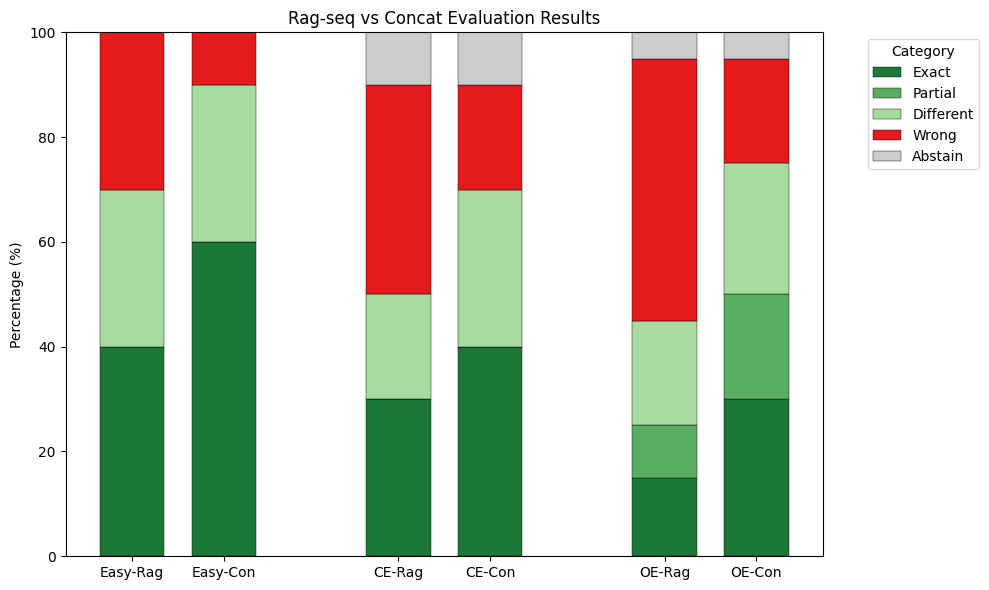

In [ ]:
# Data
data = {
    ("Rag-seq", "OE"): {"Exact": 3, "Partial": 2, "Different": 4, "Wrong": 10, "Abstain": 1},
    ("Rag-seq", "CE"): {"Exact": 3, "Partial": 0, "Different": 2, "Wrong": 4, "Abstain": 1},
    ("Rag-seq", "Easy"): {"Exact": 4, "Partial": 0, "Different": 3, "Wrong": 3, "Abstain": 0},
    ("Concat", "OE"): {"Exact": 6, "Partial": 4, "Different": 5, "Wrong": 4, "Abstain": 1},
    ("Concat", "CE"): {"Exact": 4, "Partial": 0, "Different": 3, "Wrong": 2, "Abstain": 1},
    ("Concat", "Easy"): {"Exact": 6, "Partial": 0, "Different": 3, "Wrong": 1, "Abstain": 0},
}

df = pd.DataFrame(data).T
df.index = pd.MultiIndex.from_tuples(df.index, names=["Method", "Dataset"])

# Convert to percentages
df_percent = df.div(df.sum(axis=1), axis=0) * 100

# Colors
colors = {
    "Exact": "#1b7837",
    "Partial": "#5aae61",
    "Different": "#a6dba0",
    "Wrong": "#e41a1c",
    "Abstain": "#cccccc"
}

# Flatten for plotting
df_plot = df_percent.reset_index()

datasets = ["Easy", "CE", "OE"]
methods = ["Rag-seq", "Concat"]
categories = df.columns

fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.7
group_gap = 0.9

x = []
labels = []
pos = 0
for dataset in datasets:
    for method in methods:
        row = df_plot[(df_plot["Method"]==method) & (df_plot["Dataset"]==dataset)].iloc[0]
        bottom = 0
        for cat in categories:
            val = row[cat]
            ax.bar(pos, val, bar_width, bottom=bottom, color=colors[cat], edgecolor="black", linewidth=0.3)
            bottom += val
        x.append(pos)
        labels.append(f"{dataset}-{method[:3]}")
        pos += 1
    pos += group_gap

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylabel("Percentage (%)")
ax.set_title("Rag-seq vs Concat Evaluation Results")

# Legend
ax.legend(categories, title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()
